In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from mogp import MultiOutputMarginal
from util import build_XY

In [2]:
df = pd.read_csv("../data/fastball_spin_rates_2021.csv")
df.shape

(4845, 4)

In [3]:
df.columns

Index(['pitcher_name', 'game_date', 'avg_spin_rate', 'n_pitches'], dtype='object')

In [4]:
df.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches
0,"Wainwright, Adam",2021-04-03,2127.415000,12
1,"Wainwright, Adam",2021-04-08,2179.723000,11
2,"Wainwright, Adam",2021-04-14,2297.968571,7
3,"Wainwright, Adam",2021-04-20,2159.150000,13
4,"Wainwright, Adam",2021-04-26,2314.515455,11


In [5]:
df.isna().sum()

pitcher_name     0
game_date        0
avg_spin_rate    7
n_pitches        0
dtype: int64

In [6]:
df['pitcher_name'].nunique(), df['game_date'].nunique()

(262, 182)

In [7]:
df["avg_spin_rate"].describe()

count    4838.000000
mean     2262.381625
std       169.895006
min      1642.870000
25%      2146.792611
50%      2263.186250
75%      2378.541008
max      2899.950000
Name: avg_spin_rate, dtype: float64

### Top 10 pitcher

In [8]:
# Get tip pitchers by attending most games
n_outputs = 5
top_pitchers = df.groupby("pitcher_name")["game_date"].count().nlargest(n_outputs).reset_index()
top_pitchers = top_pitchers.reset_index().rename(columns={"index":"output_idx"})
top_pitchers

,output_idx,pitcher_name,game_date
0,0,"Rodriguez, Richard",64
1,1,"Taylor, Josh",59
2,2,"Kopech, Michael",43
3,3,"Wells, Tyler",43
4,4,"Hearn, Taylor",42


In [9]:
adf = df.loc[df["pitcher_name"].isin(top_pitchers["pitcher_name"])]
adf.shape

(251, 4)

In [10]:
adf.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches
1631,"Rodriguez, Richard",2021-04-01,2473.908333,12
1632,"Rodriguez, Richard",2021-04-06,2607.656667,3
1633,"Rodriguez, Richard",2021-04-08,2579.757000,10
1634,"Rodriguez, Richard",2021-04-12,2568.509286,14
1635,"Rodriguez, Richard",2021-04-13,2588.001111,9


In [11]:
adf["avg_spin_rate"].describe()

count     251.000000
mean     2393.891321
std       147.385561
min      2083.833333
25%      2279.867500
50%      2357.402692
75%      2520.131707
max      2712.219500
Name: avg_spin_rate, dtype: float64

In [12]:
# Standardise output
adf["avg_spin_rate"] = (adf["avg_spin_rate"] - adf["avg_spin_rate"].mean())/adf["avg_spin_rate"].std()
adf["avg_spin_rate"].describe()

/tmp/ipykernel_5454/461542218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adf["avg_spin_rate"] = (adf["avg_spin_rate"] - adf["avg_spin_rate"].mean())/adf["avg_spin_rate"].std()


count    2.510000e+02
mean    -2.172675e-15
std      1.000000e+00
min     -2.103720e+00
25%     -7.736431e-01
50%     -2.475726e-01
75%      8.565316e-01
max      2.159833e+00
Name: avg_spin_rate, dtype: float64

### Create a date index

In [13]:
adf.loc[:,"game_date"] = pd.to_datetime(adf["game_date"])

/tmp/ipykernel_5454/3223010944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adf.loc[:,"game_date"] = pd.to_datetime(adf["game_date"])


In [14]:
gdates = adf["game_date"]

In [15]:
gdates.min(), gdates.max(), gdates.nunique(), (gdates.max() - gdates.min())

(Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-10-03 00:00:00'),
 142,
 Timedelta('185 days 00:00:00'))

In [16]:
dates_idx = pd.DataFrame({"game_date":pd.date_range(gdates.min(), gdates.max())}).reset_index()
dates_idx = dates_idx.rename(columns={"index":"x"})
dates_idx.head()

,x,game_date
0,0,2021-04-01
1,1,2021-04-02
2,2,2021-04-03
3,3,2021-04-04
4,4,2021-04-05


### Create training data

In [17]:
adf = adf.merge(dates_idx, how="left", on="game_date")
adf = adf.merge(top_pitchers[["pitcher_name", "output_idx"]], how="left", on="pitcher_name")
adf.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches,x,output_idx
0,"Rodriguez, Richard",2021-04-01,0.542909,12,0,0
1,"Rodriguez, Richard",2021-04-06,1.450382,3,5,0
2,"Rodriguez, Richard",2021-04-08,1.261085,10,7,0
3,"Rodriguez, Richard",2021-04-12,1.184770,14,11,0
4,"Rodriguez, Richard",2021-04-13,1.317020,9,12,0


In [18]:
adf = adf.sort_values(["output_idx", "x"])
X = adf[["x", "output_idx"]].values
Y = adf["avg_spin_rate"].values
X.shape, Y.shape

((251, 2), (251,))

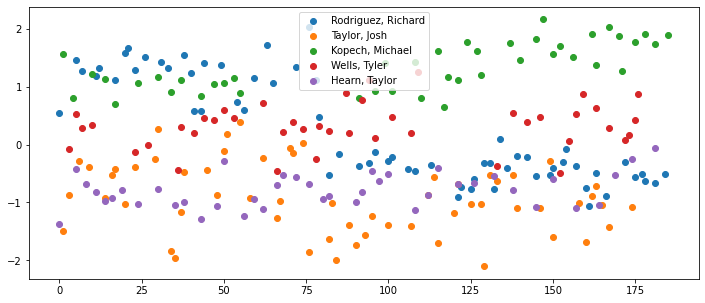

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
legends = []
for pitcher in top_pitchers["pitcher_name"]:
    cond = adf["pitcher_name"] == pitcher
    ax.scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"])
    legends.append(pitcher)
plt.legend(legends)

### GP model with LCM (2 or more kernels)

In [20]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    # kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(input_dim=2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Define a Multi-output GP 
    mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=n_outputs)    
    y_ = mogp.marginal_likelihood("f", X, Y, noise=sigma)    

In [21]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 378 seconds.


CPU times: user 17min 59s, sys: 32min 20s, total: 50min 19s
Wall time: 6min 26s


In [22]:
M = 200
x_new = np.linspace(0, 200, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape

(1000, 2)

In [23]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 12min 40s, sys: 10min 9s, total: 22min 50s
Wall time: 2min 58s


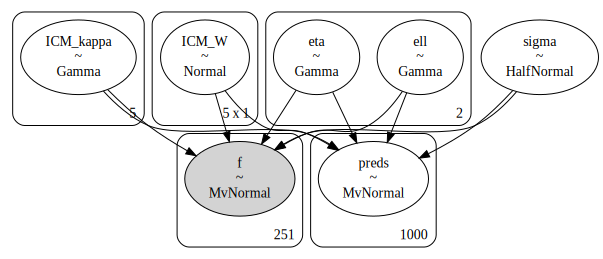

In [24]:
pm.model_to_graphviz(model)

In [25]:
top_pitchers["pitcher_name"]

0    Rodriguez, Richard
1          Taylor, Josh
2       Kopech, Michael
3          Wells, Tyler
4         Hearn, Taylor
Name: pitcher_name, dtype: object

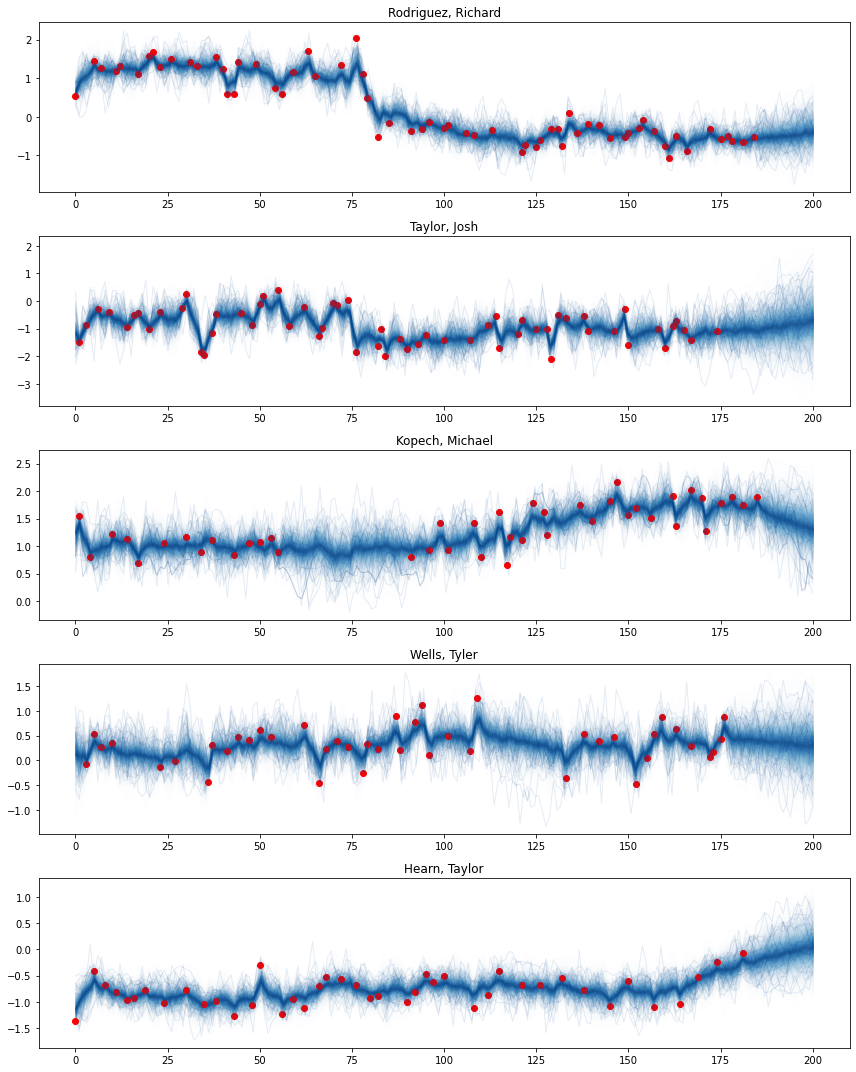

In [26]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, pitcher in enumerate(top_pitchers["pitcher_name"]):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
    cond = adf["pitcher_name"] == pitcher
    axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], color='r')
    axes[idx].set_title(pitcher)
plt.tight_layout()

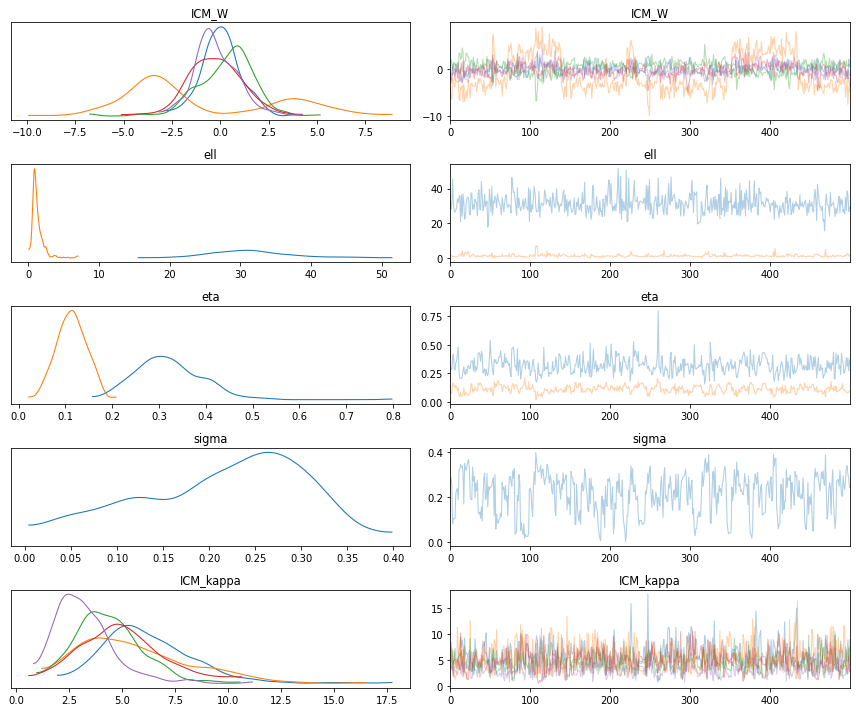

In [27]:
az.plot_trace(gp_trace);
plt.tight_layout()

### GP model with LCM (2 or more kernels)

In [29]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    # kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(input_dim=2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    # Add a Periodic kernel
    cov_period = pm.gp.cov.Periodic(input_dim=2, period=28, ls=2, active_dims=[1])
    cov_list.append(cov_period)
    
    # Define a Multi-output GP 
    mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=n_outputs)    
    y_ = mogp.marginal_likelihood("f", X, Y, noise=sigma)    

In [30]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 372 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5045, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 17min 18s, sys: 30min 51s, total: 48min 9s
Wall time: 6min 24s


In [31]:
M = 200
x_new = np.linspace(0, 200, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape

(1000, 2)

In [32]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 12min 56s, sys: 10min 25s, total: 23min 22s
Wall time: 3min 6s


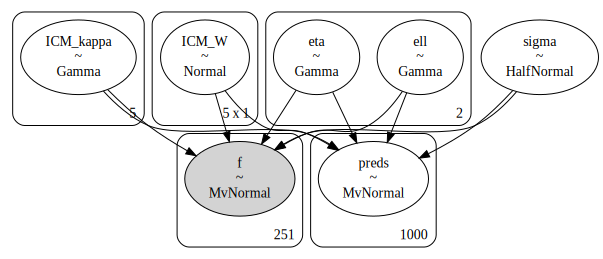

In [33]:
pm.model_to_graphviz(model)

In [34]:
top_pitchers["pitcher_name"]

0    Rodriguez, Richard
1          Taylor, Josh
2       Kopech, Michael
3          Wells, Tyler
4         Hearn, Taylor
Name: pitcher_name, dtype: object

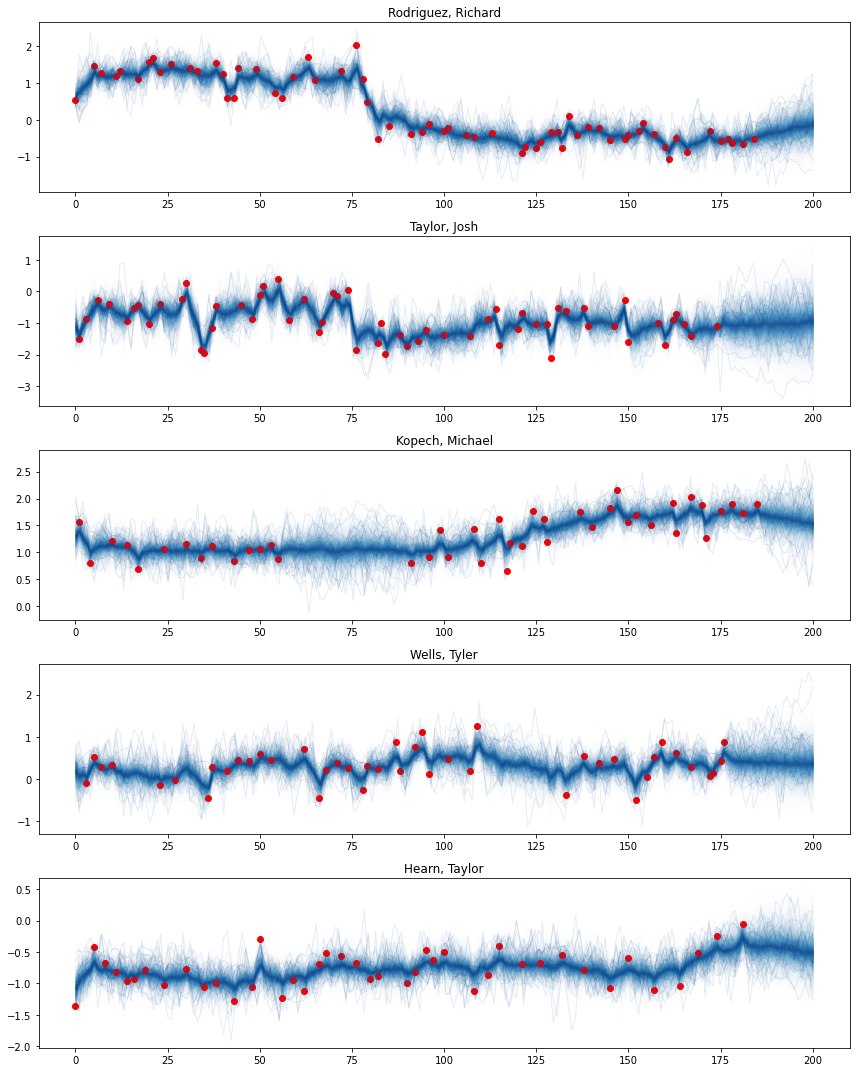

In [35]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, pitcher in enumerate(top_pitchers["pitcher_name"]):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
    cond = adf["pitcher_name"] == pitcher
    axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], color='r')
    axes[idx].set_title(pitcher)
plt.tight_layout()

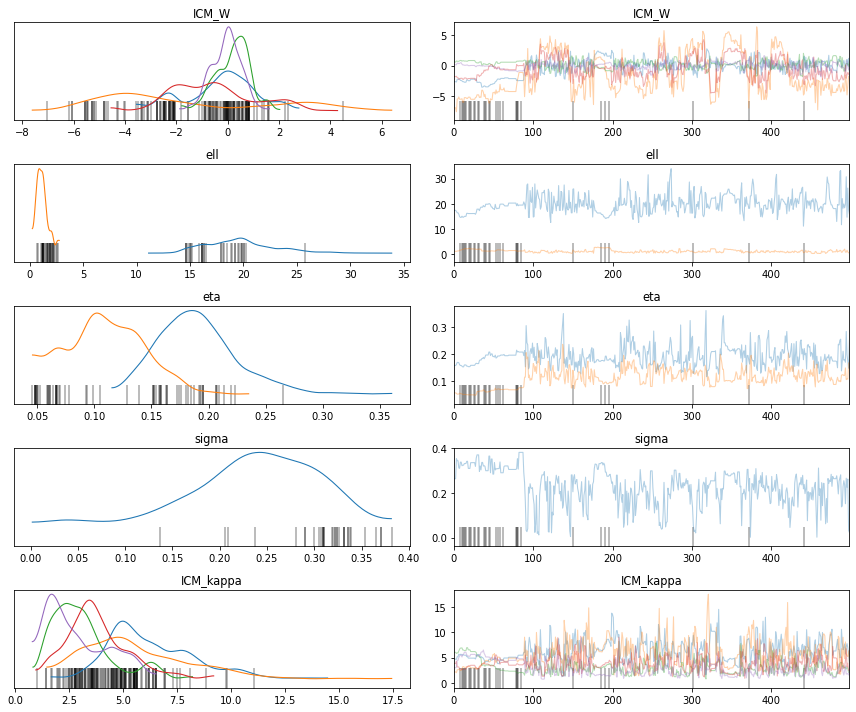

In [36]:
az.plot_trace(gp_trace);
plt.tight_layout()